In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import math

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
from pandas_datareader import data as pdr
import yfinance as yf

import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff
from afml.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from afml.sample_weights.attribution import get_weights_by_return, get_weights_by_time_decay
from afml.feature_importance.importance import mean_decrease_impurity, mean_decrease_accuracy, single_feature_importance, plot_feature_importance
from afml.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.utils import resample
from sklearn.utils import shuffle

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Import Dataset

In [6]:
# df_yf = gd.get_yf_data(tickers= "SPY COMP ALGM", 
#                     period='60d',   
#                     interval='5m'
# )

# df = df_yf[df_yf['Ticker'] == 'ALGM']
# index_SPY = df_yf[df_yf['Ticker'] == 'SPY']
# index_COMP = df_yf[df_yf['Ticker'] == 'COMP']

In [7]:
# download dataframe

yf.pdr_override()

def get_yf_daily(ticker, startdate, enddate, years):
    df = pd.DataFrame()
    for i in range(years):
        start = startdate.replace(startdate.year-i).strftime('%Y-%m-%d')
        end = enddate.replace(enddate.year-i).strftime('%Y-%m-%d')
        thisdf = pdr.get_data_yahoo(ticker, start=start, end=end)
        df= pd.concat([df, thisdf], axis= 0)
        print('Complete {} {}'.format(ticker, enddate.year-i))
    return df

years = 10
startdate= datetime.date(2021, 1, 1)
enddate = datetime.date(2021, 12, 31)

df = get_yf_daily('STBA', startdate, enddate, years).sort_index(ascending=True)
index_SPY = get_yf_daily('SPY', startdate, enddate, years).sort_index(ascending=True)
#index_COMP = get_yf_daily('COMP', startdate, enddate, years)


[*********************100%***********************]  1 of 1 completed
Complete STBA 2021
[*********************100%***********************]  1 of 1 completed
Complete STBA 2020
[*********************100%***********************]  1 of 1 completed
Complete STBA 2019
[*********************100%***********************]  1 of 1 completed
Complete STBA 2018
[*********************100%***********************]  1 of 1 completed
Complete STBA 2017
[*********************100%***********************]  1 of 1 completed
Complete STBA 2016
[*********************100%***********************]  1 of 1 completed
Complete STBA 2015
[*********************100%***********************]  1 of 1 completed
Complete STBA 2014
[*********************100%***********************]  1 of 1 completed
Complete STBA 2013
[*********************100%***********************]  1 of 1 completed
Complete STBA 2012
[*********************100%***********************]  1 of 1 completed
Complete SPY 2021
[*********************100%*******

## Raw Data 

In [8]:
# Drop the NaN values from our data set
df.dropna(axis=0, how='any', inplace=True)
index_SPY.dropna(axis=0, how='any', inplace=True)


## Form Dollar Bars

In [9]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20
#frequency = df['Volume'].resample('D').sum().mean()/10.0

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 


In [10]:
# construct the input data
_index_SPY = index_SPY.reset_index()
trades_SPY = _index_SPY[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency_SPY = _index_SPY.Volume.mean()*20
#frequency = df['Volume'].resample('D').sum().mean()/10.0

# generate the dollar bars
dollar_bars_SPY = bars.generate_dollarbars(trades_SPY, frequency=frequency_SPY) 


## Get Labels: Trend Scanning method

In [11]:
# convert Adj Close to numpy
#time_series = df['Adj Close'].to_numpy()
time_series = dollar_bars.close.to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = pd.DataFrame(tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='both'), 
                            index= dollar_bars.index[window_size_max-1:])

dollar_bars = dollar_bars.join(label_output, how='outer')

# Remove Look ahead biase by lagging the signal
dollar_bars['label'] = dollar_bars['label'].shift(1) 
dollar_bars['slope'] = dollar_bars['slope'].shift(1) 


## Get Labels: Simple moving average cross over strategy

In [12]:
# need to cite here ...

# compute moving averages
fast_window = 20
slow_window = 50

dollar_bars['fast_mavg'] = dollar_bars['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
dollar_bars['slow_mavg'] = dollar_bars['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

# Compute sides
dollar_bars['side'] = np.nan

long_signals = dollar_bars['fast_mavg'] >= dollar_bars['slow_mavg'] 
short_signals = dollar_bars['fast_mavg'] < dollar_bars['slow_mavg'] 
dollar_bars.loc[long_signals, 'side'] = 1
dollar_bars.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
dollar_bars['side'] = dollar_bars['side'].shift(1) 



In [13]:
# print(df['label'].value_counts())
# print(df['side'].value_counts())

print(dollar_bars['label'].value_counts())
print(dollar_bars['side'].value_counts())


 1.0    875
-1.0    805
Name: label, dtype: int64
 1.0    928
-1.0    709
Name: side, dtype: int64


## Features: Technical Indicators

In [14]:
# Log Returns
dollar_bars['log_ret'] = np.log(dollar_bars['close']).diff()

# Momentum
dollar_bars['mom1'] = dollar_bars['close'].pct_change(periods=1).shift(1)
dollar_bars['mom2'] = dollar_bars['close'].pct_change(periods=2).shift(1)
dollar_bars['mom3'] = dollar_bars['close'].pct_change(periods=3).shift(1)
dollar_bars['mom4'] = dollar_bars['close'].pct_change(periods=4).shift(1)
dollar_bars['mom5'] = dollar_bars['close'].pct_change(periods=5).shift(1)

# Volatility
dollar_bars['volatility_50'] = dollar_bars['log_ret'].rolling(window=50, min_periods=3, center=False).std().shift(1)
dollar_bars['volatility_31'] = dollar_bars['log_ret'].rolling(window=31, min_periods=3, center=False).std().shift(1)
dollar_bars['volatility_15'] = dollar_bars['log_ret'].rolling(window=15, min_periods=3, center=False).std().shift(1)

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

dollar_bars['autocorr_1'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=1), raw=False).shift(1)
dollar_bars['autocorr_2'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=2), raw=False).shift(1)
dollar_bars['autocorr_3'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=3), raw=False).shift(1)
dollar_bars['autocorr_4'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=4), raw=False).shift(1)
dollar_bars['autocorr_5'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=5), raw=False).shift(1)

# Get the various log -t returns
dollar_bars['log_t1'] = dollar_bars['log_ret'].shift(1)
dollar_bars['log_t2'] = dollar_bars['log_ret'].shift(2)
dollar_bars['log_t3'] = dollar_bars['log_ret'].shift(3)
dollar_bars['log_t4'] = dollar_bars['log_ret'].shift(4)
dollar_bars['log_t5'] = dollar_bars['log_ret'].shift(5)

#Correct lookahead bias
dollar_bars['fast_mavg'] = dollar_bars['fast_mavg'].shift(1)
dollar_bars['slow_mavg'] = dollar_bars['slow_mavg'].shift(1)

c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


In [15]:
dollar_bars = dollar_bars.dropna()

# define closing price
close = dollar_bars.close.copy()

## Filter Events using CUSUM Filter

We will then predict what will happen if the event is triggered, based on the 'side' signal from the Trend Following Strategy 

In [16]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed threshold
#tEvents = flt.getTEvents(close, h=dailyVolatility.mean()*0.5)
tEvents = flt.cusum_filter(close, threshold=dailyVolatility.mean()*0.5, signal=None)

# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [17]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(dollar_bars.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

## Create Trade or Not Trade labels using Triple Barrier Method

In [18]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents, 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()

labels = tbar.get_bins(triple_barrier_events = events, close=close)

# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)
print(clean_labels.bin.value_counts())

0    731
1    140
Name: bin, dtype: int64


## Results of Secondary Model without features

In [19]:
primary_forecast = pd.DataFrame(clean_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       731
           1       0.16      1.00      0.28       140

    accuracy                           0.16       871
   macro avg       0.08      0.50      0.14       871
weighted avg       0.03      0.16      0.04       871

Confusion Matrix
[[  0 731]
 [  0 140]]

Accuracy
0.16073478760045926


#### Fitting a Meta model

Use features: volatility, serial correlation, relative strength to S&P and COMP

In [20]:
# Save the raw data
raw_data = dollar_bars.drop(columns='close').copy()

raw_data.head()

,open,high,low,volume,slope,label,fast_mavg,slow_mavg,side,log_ret,...,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
time,,,,,,,,,,,,,,,,,,,,,
2012-06-20,12.726014,12.955830,12.726014,195800.0,-0.147226,-1.0,13.141833,14.380621,-1.0,-0.015642,...,0.100730,-0.212205,0.135790,0.201050,-0.050958,0.016206,0.037307,0.007043,0.016627,-0.023670
2012-06-22,12.575197,12.934290,12.575197,293400.0,-0.043093,-1.0,13.050167,14.352660,-1.0,0.013978,...,0.093120,-0.221598,0.131380,0.191783,-0.043129,-0.015642,0.016206,0.037307,0.007043,0.016627
2012-06-27,12.603926,12.963016,12.603926,166200.0,0.234843,1.0,12.929013,14.325459,-1.0,0.002218,...,0.079497,-0.210332,0.144759,0.188078,-0.040605,0.013978,-0.015642,0.016206,0.037307,0.007043
2012-07-02,12.919924,13.329282,12.919924,231100.0,0.276497,1.0,12.817843,14.293030,-1.0,0.027863,...,0.084401,-0.217132,0.132336,0.179125,-0.045206,0.002218,0.013978,-0.015642,0.016206,0.037307
2012-07-09,13.501640,13.595010,13.429825,171300.0,0.163026,1.0,12.788382,14.269766,-1.0,0.007515,...,0.087873,-0.198719,0.121636,0.193536,-0.007262,0.027863,0.002218,0.013978,-0.015642,0.016206


#### Technical Features

In [21]:
# # Re compute sides
# raw_data['side'] = np.nan

# long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
# short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

# raw_data.loc[long_signals, 'side'] = 1
# raw_data.loc[short_signals, 'side'] = -1

In [22]:
raw_data.columns

Index(['open', 'high', 'low', 'volume', 'slope', 'label', 'fast_mavg',
       'slow_mavg', 'side', 'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5',
       'volatility_50', 'volatility_31', 'volatility_15', 'autocorr_1',
       'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_t1',
       'log_t2', 'log_t3', 'log_t4', 'log_t5'],
      dtype='object')

In [23]:
# serial correlation
srl_corr = mkt.df_rolling_autocorr(mkt.returns(close), window=7).rename('srl_corr')

# relative strength to SPY
rs_SPY = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(1).dropna()

# relative strength to COMP
#rs_COMP = mkt.get_relative_strength(df['Adj Close'], index_COMP['Adj Close']).shift(1).dropna()


In [24]:
# fractional differentiated log dollar bar prices

# cumulative sum of stock log-prices
ticker_log_cumsum = np.log(dollar_bars.close).cumsum()

# frac diff 1 time
dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()

# apply cumsum filter
dfx1_close = dfx1.close.copy()
df_tEvents = flt.getTEvents(dfx1_close, h=dfx1.std().iat[0]*2)

# fracDiff value feature
frac_diff_feat = dfx1.loc[df_tEvents] 


In [25]:
features = (pd.DataFrame()
            #.assign(vol=events.trgt)
            #.assign(side=clean_labels.side)
            #.assign(srl_corr=srl_corr)
            .assign(rs_SPY=rs_SPY)
            #.assign(rs_COMP=rs_COMP)
            #.assign(frac_diff_feat=frac_diff_feat)
            .drop_duplicates()
            .dropna())

In [26]:
# Get features at event dates
_X = raw_data.loc[clean_labels.index, :]

In [27]:
# Drop unwanted columns
_X.drop([#'Ticker',
        'high', 'low', 'open', 'volume', 'log_ret'
        #'fast_mavg', 'slow_mavg', 'side', # remove for MA crossover
        #'slope', 'label', # remove for trend scanning
        ], axis=1, inplace=True)

In [28]:
Xy = _X.join(features).join(clean_labels['bin']).dropna()

In [29]:
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]

In [30]:
y.value_counts()

0    731
1    140
Name: bin, dtype: int64

In [31]:
Xy.columns

Index(['slope', 'label', 'fast_mavg', 'slow_mavg', 'side', 'mom1', 'mom2',
       'mom3', 'mom4', 'mom5', 'volatility_50', 'volatility_31',
       'volatility_15', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4',
       'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5',
       'rs_SPY', 'bin'],
      dtype='object')

In [32]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=RANDOM_STATE)

## Sample Weights

In [33]:
# training data sample weights

return_based_sample_weights = get_weights_by_return(events.loc[X_train.index], dollar_bars.loc[X_train.index, 'close'])
time_based_sample_weights = get_weights_by_time_decay(events.loc[X_train.index], dollar_bars.loc[X_train.index, 'close'], decay=0.5)

# test data sample weights

return_based_sample_weights_test = get_weights_by_return(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'])
time_based_sample_weights_test = get_weights_by_time_decay(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'], decay=0.5)

2023-03-25 00:32:10.441783 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:11.829841 100.0% _apply_weight_by_return done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:13.242049 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:14.401666 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:15.470029 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:16.575540 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:17.671568 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-25 00:32:18.761915 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


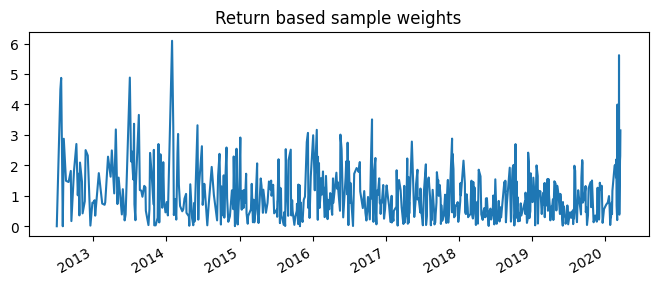

In [34]:
plt.figure(figsize=(8,3))
plt.title('Return based sample weights')
return_based_sample_weights.plot()
plt.show()

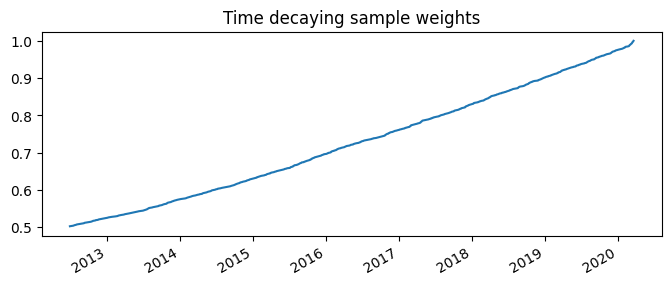

In [35]:
plt.figure(figsize=(8,3))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

## Cross-Validation 

In [36]:
def get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring, sample_weight, scaler=StandardScaler()):
    t0 = 0.0
    t1 = 0.0

    best_param_dict = {}
    best_param_dict['type'] = type
    best_param_dict['top_model'] = None
    best_param_dict['max_cross_val_score'] = -np.inf
    best_param_dict['max_cross_val_score_recall'] = -np.inf
    best_param_dict['max_cross_val_score_precision'] = -np.inf
    best_param_dict['max_cross_val_score_accuracy'] = -np.inf
    best_param_dict['run_time'] = 0.0

    col = X_train.columns.to_list()
    idx = X_train.index

    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col, index=idx)

    t0 = time.time()
    temp_score_base, temp_recall, temp_precision, temp_accuracy = ml_cross_val_score(clf, X_train_scaled, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)
    t1 = time.time()
    
    if temp_score_base.mean() > best_param_dict['max_cross_val_score']:
        best_param_dict['top_model'] = clf
        best_param_dict['max_cross_val_score'] = temp_score_base.mean()
        best_param_dict['max_cross_val_score_recall'] = temp_recall.mean()
        best_param_dict['max_cross_val_score_precision'] = temp_precision.mean()
        best_param_dict['max_cross_val_score_accuracy'] = temp_accuracy.mean()
        best_param_dict['run_time'] = t1-t0    
    
    return best_param_dict

def perform_grid_search(X_train, y_train, cv_gen, scoring, parameters, events, dollar_bars, type='standard', sample_weight=None, RANDOM_STATE=42):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """

    if type=='SVC' or type=='seq_boot_SVC':
        for C in parameters['C']:
            for gamma in parameters['gamma']:

                clf_SVC = SVC(C=C,
                                gamma=gamma,
                                class_weight='balanced',
                                kernel='linear',
                                random_state=RANDOM_STATE)

                if type =='SVC':
                    clf = clf_SVC
                elif type == 'seq_boot_SVC':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                estimator=clf_SVC, 
                                                                random_state=RANDOM_STATE, n_jobs=-1, oob_score=False,
                                                                max_features=1.)

                # get best param dict   
                best_param_dict = get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)


    else:    
        for m_depth in parameters['max_depth']:
            for n_est in parameters['n_estimators']:
                clf_base = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, 
                                                max_depth=m_depth, class_weight='balanced')

                if type == 'standard_bagging':
                    clf = BaggingClassifier(n_estimators=n_est, 
                                            estimator=clf_base, 
                                            random_state=RANDOM_STATE, n_jobs=-1, 
                                            oob_score=False, max_features=1.)
                elif type == 'random_forest':
                    clf = RandomForestClassifier(n_estimators=n_est, 
                                                max_depth=m_depth, 
                                                random_state=RANDOM_STATE, 
                                                n_jobs=-1, 
                                                oob_score=False, 
                                                criterion='entropy',
                                                class_weight='balanced_subsample', 
                                                max_features=1.)
                elif type == 'sequential_bootstrapping':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                    price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                    estimator=clf_base, 
                                                                    n_estimators=n_est, 
                                                                    random_state=RANDOM_STATE, 
                                                                    n_jobs=-1, 
                                                                    oob_score=False,
                                                                    max_features=1.)
                
                # get best param dict   
                best_param_dict = get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)

    return best_param_dict

In [37]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 25, 50, 100, 250, 500],
              'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              }

In [38]:
n_splits=4

cv_gen_standard = KFold(n_splits)
cv_gen_purged = PurgedKFold(n_splits=n_splits, samples_info_sets=events.loc[X_train.index].t1)

In [39]:
warnings.filterwarnings('ignore')

In [40]:

selected_models = ['standard_bagging', 
                   'random_forest', 
                   'sequential_bootstrapping', 
                   'SVC', 
                   'seq_boot_SVC'
                   ]

model_metrics = pd.DataFrame(columns = ['type', 'top_model', 'max_cross_val_score', 'max_cross_val_score_recall', 'max_cross_val_score_precision', 'max_cross_val_score_accuracy','run_time'])


for clf in selected_models:
    best_params = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, events, dollar_bars, type=clf, sample_weight=return_based_sample_weights.values)
    model_metrics = model_metrics.append(best_params, ignore_index = True)  
    print('Completed {}'.format(clf))


Completed standard_bagging
Completed random_forest
Completed sequential_bootstrapping
Completed SVC
Completed seq_boot_SVC


In [41]:
model_metrics

,type,top_model,max_cross_val_score,max_cross_val_score_recall,max_cross_val_score_precision,max_cross_val_score_accuracy,run_time
0,standard_bagging,(DecisionTreeClassifier(class_weight='balanced...,0.000000,0.000000,0.000000,0.803755,2.435167
1,random_forest,"(DecisionTreeClassifier(criterion='entropy', m...",0.000000,0.000000,0.000000,0.803755,3.904298
2,sequential_bootstrapping,(DecisionTreeClassifier(class_weight='balanced...,0.013530,0.007204,0.110933,0.804778,97.461209
3,SVC,"SVC(C=1000, class_weight='balanced', gamma=0.0...",0.271037,0.453242,0.203584,0.552332,34.706936
4,seq_boot_SVC,"(SVC(C=1000, class_weight='balanced', gamma=0....",0.235327,0.378809,0.191575,0.553719,68.300121


In [42]:
top_model = model_metrics.sort_values(['max_cross_val_score']).tail(1)['top_model'].squeeze()
top_model

SVC(C=1000, class_weight='balanced', gamma=0.0001, kernel='linear',
    random_state=42)

In [44]:
best_SVC = model_metrics[model_metrics['type'] == 'seq_boot_SVC']['top_model'].squeeze()
best_SVC

SequentiallyBootstrappedBaggingClassifier(estimator=SVC(C=1000,
                                                        class_weight='balanced',
                                                        gamma=0.0001,
                                                        kernel='linear',
                                                        random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2012-07-02    13.329282
2012-07-09    13.429825
2012-07-12    13.480095
2012-07-17    13.630909
2012-07-20    13.092281
                ...    
2020-03-12    21.883146
2020-03-13    24.112150
2020-03-16    22.104280
2020-03-17    25.527391
2020-03-18    23.492985
Name: close, Length: 1215, dtype: float64,
                                          random_state=42,
                                          samples_info_sets=2012-07-02   2012-07-12
2012-07-20   2012-07-24
2012-07-24   2012-08-01
2012-08-01   2012-08-06
2012-08-06   2012-08-17
                ...    
2020-03-12   2020-03-13
2020-03-13   2020-03-16
2020-03-16   2020-03-17
2020-03-17   2020-03-20
2020-03-18   2020-03-26
Name: t1, Length: 609, dtype: datetime64[ns])

## Feature Importance

The SVC classifier does not provide a direct wat to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

In [45]:
# Get coefficients of hyperplane
coef = best_SVC.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()


AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute 'coef_'

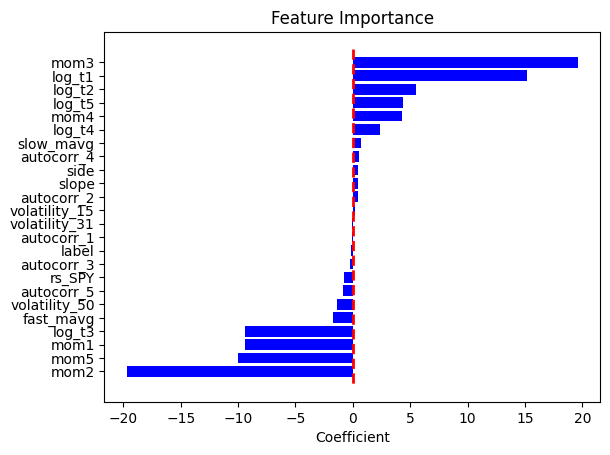

In [46]:
# Get coefficients of hyperplane
coef = top_model.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()

This codes below are for tress based Feature Importance

In [ ]:
# # MDI, MDA, SFI feature importance
# mdi_feat_imp = mean_decrease_impurity(top_model, X_train.columns)
# mda_feat_imp = mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring='f1', sample_weight=sw_train)
# sfi_feat_imp = single_feature_importance(top_model, X_train, y_train, cv_gen_purged, scoring='f1', sample_weight=sw_train)

In [ ]:
# plot_feature_importance(mdi_feat_imp, 0, 0)

In [ ]:
# plot_feature_importance(mda_feat_imp, 0, 0)

In [ ]:
# plot_feature_importance(sfi_feat_imp, 0, 0)

## Top Model Metrics

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       216
           1       0.00      0.00      0.00        46

    accuracy                           0.81       262
   macro avg       0.41      0.49      0.45       262
weighted avg       0.68      0.81      0.74       262



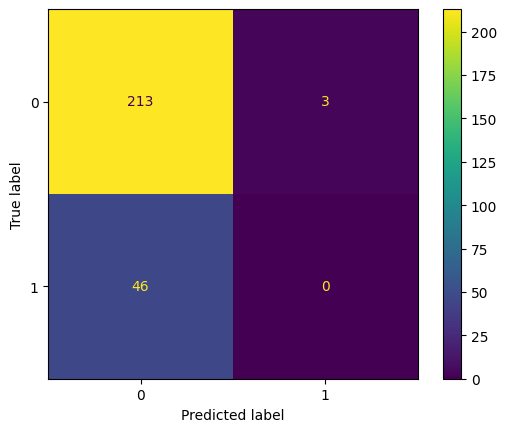

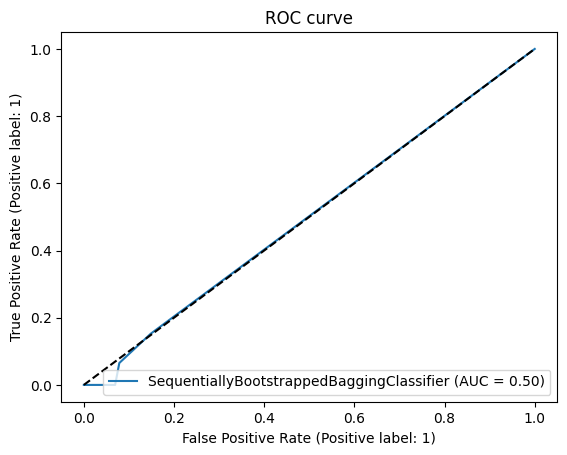

In [47]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score

#best_SVC_fitted = best_SVC.fit(X_train, y_train, sample_weight=return_based_sample_weights.values)
#y_pred = best_SVC_fitted.predict(X_test)
y_pred = best_SVC.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_SVC, X_test, y_test)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_SVC, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       216
           1       0.00      0.00      0.00        46

    accuracy                           0.82       262
   macro avg       0.41      0.50      0.45       262
weighted avg       0.68      0.82      0.74       262

0.0


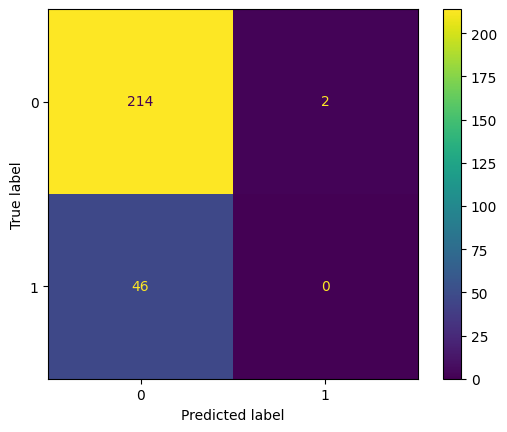

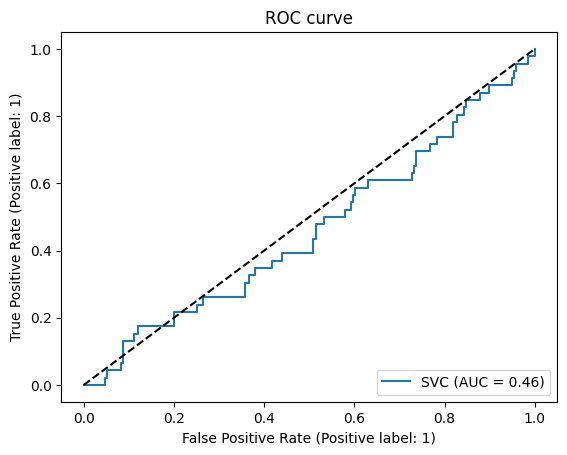

In [49]:
y_pred = top_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(top_model, X_test, y_test)
plt.show()

RocCurveDisplay.from_estimator(top_model, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

## Backtest

In [ ]:
clean_labels

In [ ]:
test_result_df = X_test[['slope', 'label']]
test_result_df['y_test'] = y_test
test_result_df['y_pred'] = y_pred

In [ ]:
test_result_df[test_result_df['label']==1].groupby('y_test').sum()


In [ ]:
import pandas as pd
   
   # Load the data
data = pd.read_csv('your_data.csv')
   
   # Calculate the daily returns
data['daily_returns'] = data['log_returns'].apply(lambda x: math.exp(x) - 1)

In [ ]:
# Define transaction cost and slippage parameters
transaction_cost = 0.01  # 1% transaction cost
slippage = 0.005  # 0.5% slippage

# Calculate the trade returns
data['trade_returns'] = data['daily_returns'] * data['trade'].shift(1) - abs(data['trade'].diff()) * (transaction_cost + slippage)

In [ ]:
# Calculate the cumulative returns
data['cumulative_returns'] = (data['trade_returns'] + 1).cumprod() - 1

In [ ]:
# Line chart of the cumulative returns over time.

In [ ]:
import matplotlib.pyplot as plt
   
   # Visualize the results
plt.plot(data['date'], data['cumulative_returns'])
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.show()